# サイコロの目の和

In [7]:
from collections import defaultdict

#確率分布のdict作成
dist = {i:1/6 for i in range(1, 7)}

#2次元確率分布計算
dist_multi = defaultdict(lambda: 0)
for key1, v1 in dist.items():
    for key2, v2 in dist.items():
        dist_multi[key1 + key2] += v1*v2

#期待値計算
E = 0
for key ,v in dist_multi.items():
    E += key*v

print(E)

7.0


# 分布モデルとサンプルモデル

In [8]:
import numpy as np

def sample(dices=2):
    x = 0
    for _ in range(dices):
        x += np.random.choice([1, 2, 3, 4, 5, 6])
    return x

print(sample())

6


# モンテカルロ法の実装

In [9]:
#自分の実装

n = 1000

samples = np.array([sample() for i in range(n)])
E_sample = np.mean(samples)
print(E_sample)

7.016


In [10]:
#教科書の実装

trial = 1000
V, n = 0, 0

for _ in range(trial):
    s = sample()
    n += 1
    V += (s - V) / n
print(V)

6.977999999999996


# モンテカルロ法の実装

In [11]:
import os
import sys

sys.path.append(os.path.abspath("../"))
from common.gridworld import GridWorld

env = GridWorld()
action = 0
next_state, reward, done = env.step(action)

print("next_state:", next_state)
print("reward:", reward)
print("done:", done)

next_state: (1, 0)
reward: 0
done: False


In [12]:
class RandomAgent:
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0)
        self.cnts = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def eval(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            self.cnts[state] += 1
            self.V[state] += (G - self.V[state]) / self.cnts[state]

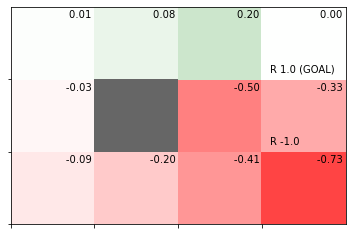

In [13]:
env = GridWorld()
agent = RandomAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.eval()
            break

        state = next_state

env.render_v(agent.V)

# モンテカルロ法による方策制御

In [14]:
def greedy_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)

    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}  #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs

class McAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1
        self.alpha = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            self.Q[key] += (G - self.Q[key]) * self.alpha
            self.pi[state] = greedy_probs(self.Q, state, self.epsilon)

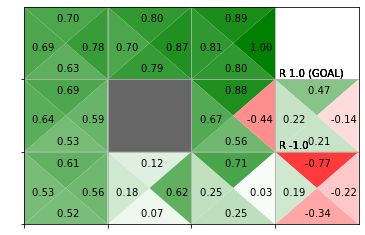

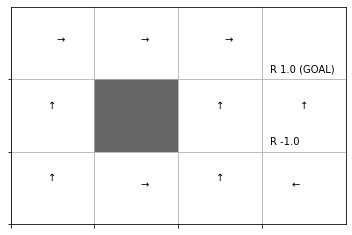

In [15]:
env = GridWorld()
agent = McAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break

        state = next_state

env.render_q(agent.Q)

# 方策オフ型と重点サンプリング

In [25]:
import numpy as np

x = np.array([1, 2, 3])
pi = np.array([0.1, 0.1, 0.8])

# =========== Expectation ==================
e = np.sum(x * pi)
print('E_pi[x]', e)

# =========== Monte Carlo ==================
n = 100
samples = []
for _ in range(n):
    s = np.random.choice(x, p=pi)
    samples.append(s)
print('MC: {:.2f} (var: {:.2f})'.format(np.mean(samples), np.var(samples)))

# =========== Importance Sampling ===========
b = np.array([0.2, 0.2, 0.6])  
#b = np.array([1/3, 1/3, 1/3])
samples = []
for _ in range(n):
    idx = np.arange(len(b))  # [0, 1, 2]
    i = np.random.choice(idx, p=b)
    s = x[i]
    rho = pi[i] / b[i]
    samples.append(rho * s)
print('IS: {:.2f} (var: {:.2f})'.format(np.mean(samples), np.var(samples)))

E_pi[x] 2.7
MC: 2.77 (var: 0.32)
IS: 2.70 (var: 10.14)


In [26]:
class McOffPolicyAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1
        self.alpha = 0.2
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.b[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        rho = 1

        for data in reversed(self.memory):
            state, action, reward = data
            key = (state, action)

            G = self.gamma * rho * G + reward
            self.Q[key] += (G - self.Q[key]) * self.alpha
            rho *= self.pi[state][action] / self.b[state][action]

            self.pi[state] = greedy_probs(self.Q, state, epsilon=0)
            self.b[state] = greedy_probs(self.Q, state, self.epsilon)

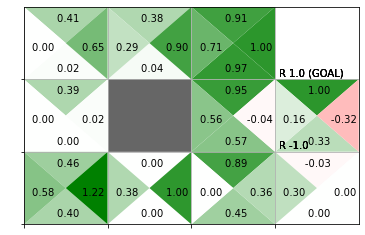

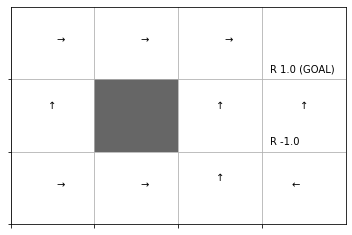

In [27]:
env = GridWorld()
agent = McOffPolicyAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break

        state = next_state

env.render_q(agent.Q)